In [6]:
import ROOT as r
import math
import array
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from math import pi
import pandas as pd

#______________Add include directory_______________
current_dir = os.getcwd()
include_dir = os.path.join(current_dir, '../include')
sys.path.insert(0, include_dir)
#__________________________________________________
import ERROR
import CONFIG
import DBPARSE
from PXPY import *
from ASYMMETRY import *
from UTILITIES import *
from SIMFITS import DistributionFits
from ROOT import gStyle, TChain, TH1F, TCanvas, TLegend
import CORRECTIONS
import CALCULATE
import GETFF
from joblib import Parallel, delayed
import importlib
#importlib.reload(ASYMMETRY)

Welcome to JupyROOT 6.26/06


In [7]:
Pass="2"
config="4b"

In [8]:
W2min=CONFIG.Function_JSON("W2min",f"../config/Pass{Pass}/cuts{config}.cfg")
W2max=CONFIG.Function_JSON("W2max",f"../config/Pass{Pass}/cuts{config}.cfg")
dxmin=CONFIG.Function_JSON("dxmin",f"../config/Pass{Pass}/cuts{config}.cfg")
dxmax=CONFIG.Function_JSON("dxmax",f"../config/Pass{Pass}/cuts{config}.cfg")
dymin=CONFIG.Function_JSON("dymin",f"../config/Pass{Pass}/cuts{config}.cfg")
dymax=CONFIG.Function_JSON("dymax",f"../config/Pass{Pass}/cuts{config}.cfg")
hcalmin=CONFIG.Function_JSON("hcalmin",f"../config/Pass{Pass}/cuts{config}.cfg")

dybgmin=CONFIG.Function_JSON("dybgmin",f"../config/Pass{Pass}/cuts{config}.cfg")
dybgmax=CONFIG.Function_JSON("dybgmax",f"../config/Pass{Pass}/cuts{config}.cfg")
coinmin=CONFIG.Function_JSON("coinmin",f"../config/Pass{Pass}/cuts{config}.cfg")
coinmax=CONFIG.Function_JSON("coinmax",f"../config/Pass{Pass}/cuts{config}.cfg")
Q2=CONFIG.Function_JSON("Q2",f"../config/Pass{Pass}/cuts{config}.cfg")

#  "dxmin"	: -0.481,
#  "dxmax"	: 0.498, old gen2


print(f'W2min: {W2min}')
print(f'W2max: {W2max}')
print(f'dxmin: {dxmin}')
print(f'dxmax: {dxmax}')
print(f'dymin: {dymin}')
print(f'dymax: {dymax}')
print(f'dybgmin: {dybgmin}')
print(f'dybgmax: {dybgmax}')
print(f'Q2: {Q2}')
print(f'Coin Min: {coinmin} Coin Max: {coinmax}')

#W2min=-1.9
#dymin=-1
#W2max=2

W2min: -1
W2max: 1.9
dxmin: -0.403
dxmax: 0.406
dymin: -0.98
dymax: 0.98
dybgmin: -1.3
dybgmax: 1.2
Q2: 9.82
Coin Min: 181 Coin Max: 190


In [9]:
generic=np.load(f"/media/research/TOSHIBA EXT/GEn/NumpyData/Pass{Pass}/GEN{config}/He3/final_2_{1}.npz")


In [10]:
%%time
if(len(generic["dx"])<3000000):
    
    useGrinch=False

    
    genericMaster = {}
    base_dir = f"/media/research/TOSHIBA EXT/GEn/NumpyData/Pass{Pass}/GEN{config}/He3"
    i = 0
    print(f"NumPy array directory = {base_dir}")
    while os.path.exists(f"{base_dir}/final_2_{i}.npz"):
        print(f"Loading in file {i}")
        if i>5:            #GPS
            break            #GPS
        file_path = f"{base_dir}/final_2_{i}.npz"
        data = np.load(file_path)

        cut=(data["ePS"]>0.2)
        if Pass=="2":
            grinchcut=(data["grinch_clus_size"]>=2)&(data["grinch_clus_trackindex"]==0)
            antigrinchcut=(data["grinch_clus_size"]<2)|(data["grinch_clus_trackindex"]!=0)
            pscut=(data["ePS"]>0) #GPS
            #pscut=(data["ePS"]>0.2)
            if useGrinch:
                print("using grinch cut")
                #cut=antigrinchcut  #ANTIG
                #cut=grinchcut
            else:
                print("using ps cut")
                cut=pscut
        for key in data.files:
            if key not in genericMaster:
                cut_data = data[key][cut]
                genericMaster[key] = cut_data

            else:
                cut_data = data[key][cut]
                genericMaster[key] = np.concatenate((genericMaster[key], cut_data))

        data.close()
        i += 1

    print(f"Loaded {i} files into genericMaster.")


NumPy array directory = /media/research/TOSHIBA EXT/GEn/NumpyData/Pass2/GEN4b/He3
Loading in file 0
using ps cut
Loading in file 1
using ps cut
Loading in file 2
using ps cut
Loading in file 3
using ps cut
Loading in file 4
using ps cut
Loading in file 5
using ps cut
Loading in file 6
Loaded 6 files into genericMaster.
CPU times: user 4.52 s, sys: 5.96 s, total: 10.5 s
Wall time: 28.9 s


In [11]:
generic=genericMaster

In [12]:
bbcalE=generic["eSH"]+generic["ePS"]
gemP=generic["trP"]

wcut=(generic["W2"] < 1.48)&(generic["W2"]>W2min) 
dycut=(generic["dy"]<dymax)&(generic["dy"]>dymin) 
dxcut=(generic["dx"] < dxmax)&(generic["dx"]>dxmin) 
coincut=(coinmin < generic["coin_time"])&(generic["coin_time"] < coinmax)
epcut=abs(bbcalE/gemP-.95)<.25
runnumcut=generic["runnum"]>2165



Text(0.5, 0, 'bb.ps.e GeV')

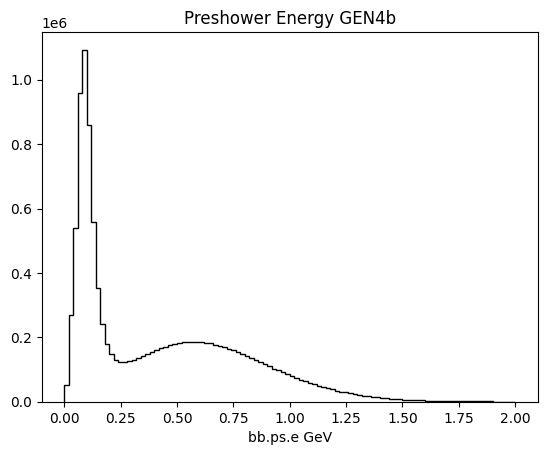

In [13]:
d=plt.hist(generic["ePS"],bins=100,range=(0,2),color='black',histtype='step')
plt.title(f"Preshower Energy GEN{config}")
plt.xlabel('bb.ps.e GeV')
#plt.yscale("log")

PS cut: 13928 (Mix of pion tail and electrons)
PS cut + antigrinch: 2386 (hopefully just pions)
Grinch cut: 12237 (hopefully just good electrons)
Base cut: 16562
Grinch/(Base-piontail): 0.8632
PS/Base: 0.8410


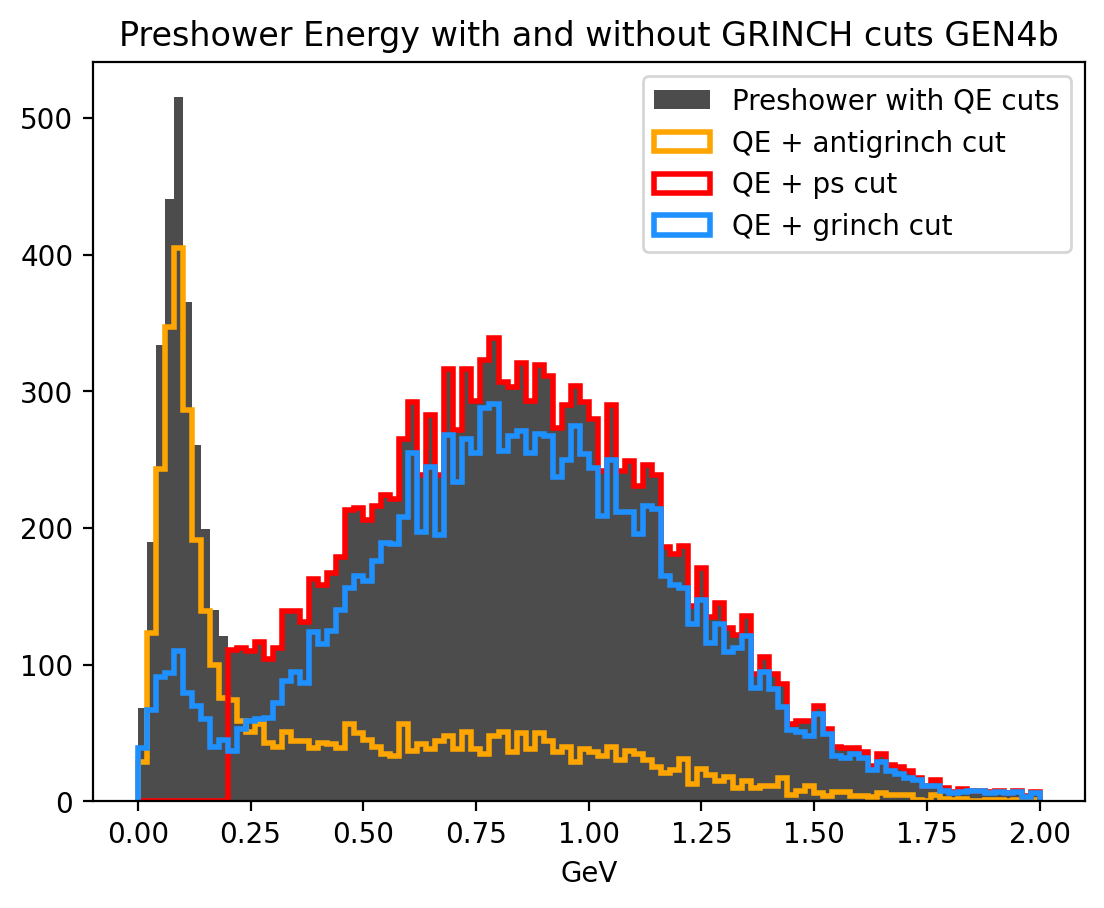

In [14]:
#to check this, uncomment out the stuff in genericMaster creation tagged GPS

plt.figure(dpi=200)
grinchcut=(generic["grinch_clus_size"]>=2)&(generic["grinch_clus_trackindex"]==0)
antigrinchcut=(generic["grinch_clus_size"]<2)|((generic["grinch_clus_trackindex"]!=0))

base=plt.hist(generic["ePS"][wcut&dxcut&dycut&coincut],bins=100,range=(0,2),
              color='black',alpha=.7,label="Preshower with QE cuts")
antigrinchhist=plt.hist(generic["ePS"][wcut&dxcut&dycut&coincut&antigrinchcut],
           bins=100,range=(0,2),histtype='step',color='orange',linewidth=2,label="QE + antigrinch cut")

pshist=plt.hist(generic["ePS"][wcut&dxcut&dycut&coincut&(generic["ePS"]>.2)],
           color='red',histtype='step',linewidth=2,bins=100,range=(0,2),alpha=1,label="QE + ps cut")

grinchhist=plt.hist(generic["ePS"][wcut&dxcut&dycut&coincut&grinchcut],bins=100,
           color='dodgerblue',histtype='step',range=(0,2),alpha=1,linewidth=2,label="QE + grinch cut")
plt.legend(loc='upper right')
plt.title(f"Preshower Energy with and without GRINCH cuts GEN{config}")
plt.xlabel("GeV")

# Total events with just QE cuts (base)
base_count = np.sum(wcut & dxcut & dycut & coincut)

# Events passing grinch cut + QE
grinch_count = np.sum(wcut & dxcut & dycut & coincut & grinchcut)

# Events passing antigrinch + QE + preshower cut (ePS > 0.2)
antigrinch_ps_count = np.sum(wcut & dxcut & dycut & coincut & antigrinchcut & (generic["ePS"] > 0.2))

# Events passing just preshower cut (QE + ePS > 0.2)
pscut_count = np.sum(wcut & dxcut & dycut & coincut & (generic["ePS"] > 0.2))

print(f"PS cut: {pscut_count} (Mix of pion tail and electrons)")
print(f"PS cut + antigrinch: {antigrinch_ps_count} (hopefully just pions)")
print(f"Grinch cut: {grinch_count} (hopefully just good electrons)")
print(f"Base cut: {base_count}")
print(f"Grinch/(Base-piontail): {grinch_count/(base_count-antigrinch_ps_count):.4f}")
print(f"PS/Base: {pscut_count/(base_count):.4f}")
